---
# KNN Implementation
The start of every machine learning project begins the same way: 
- Data Inspection
- Data Visualization
- Data Regularization
- Model implementation

Our [data](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) is a set of real estate valuates from New Taipei City,Taiwan. We will first load a dataframe and inspect the data

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import linear_model


# Load data
data_df = pd.read_csv("Real Estate.csv")

# initial inspection of the data
data_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


---
## Visualization

The dataset has 6 features and 1 output. We cannot visualize 6-dimensional data, however we can inspect each feature against the output to identify any important correlations between the features. 

Number of columns: 8


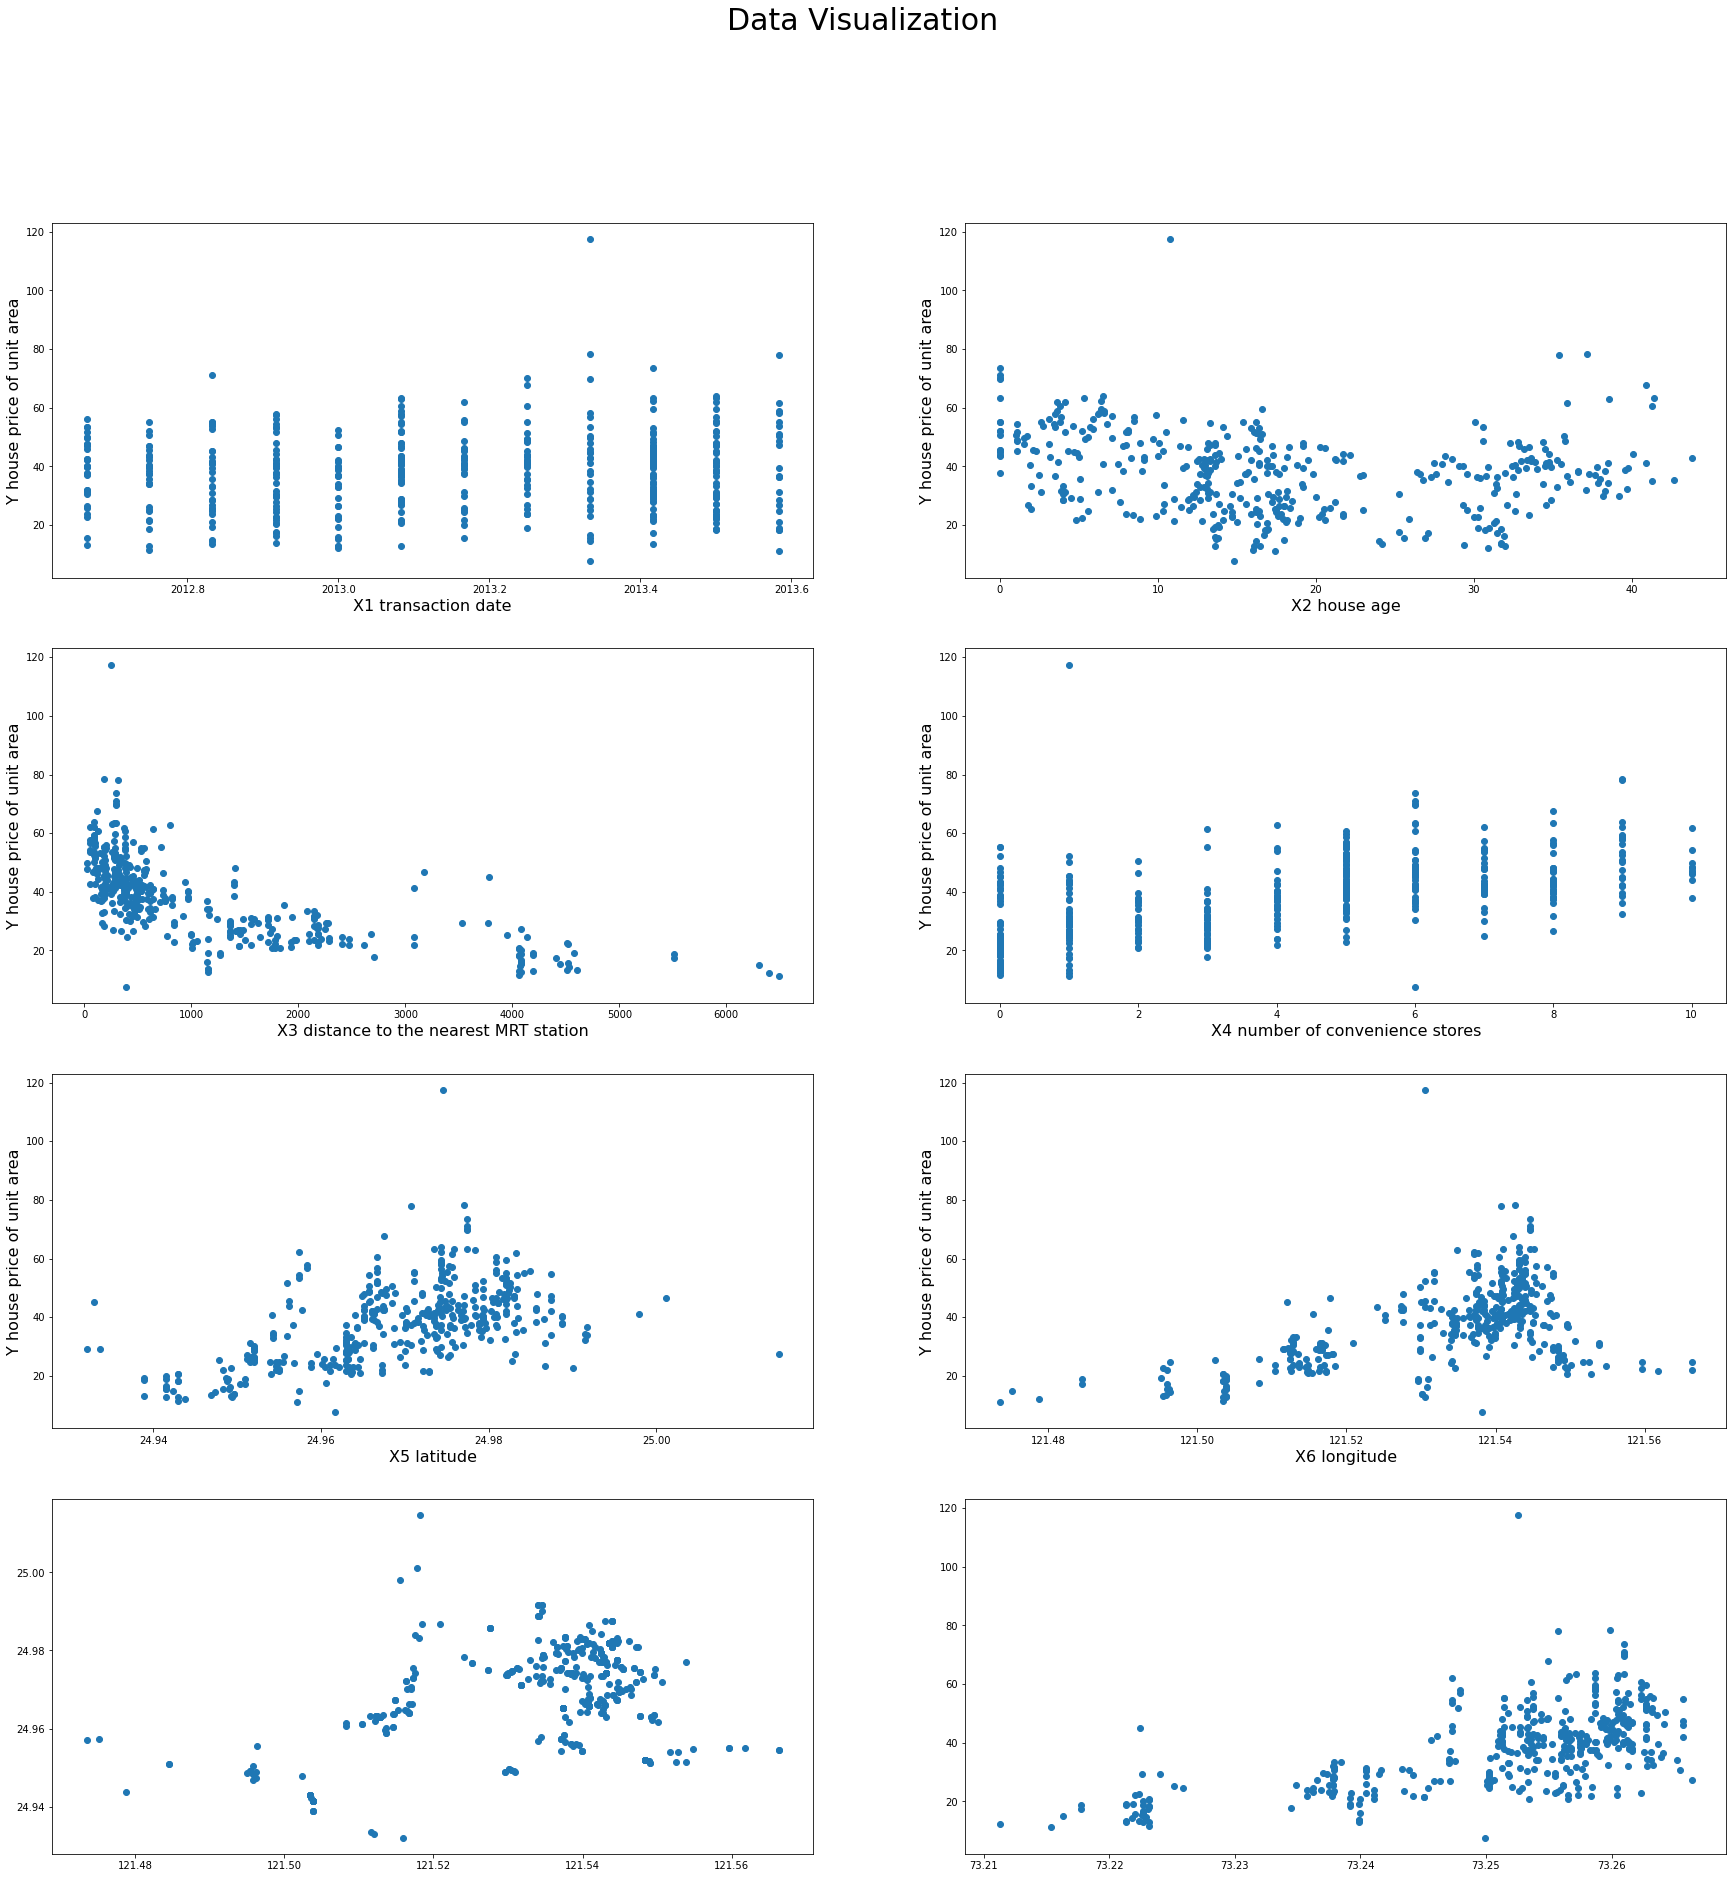

In [202]:
print(f"Number of columns: {data_df.shape[1]}")

# Plot data to identify trends
fig, axs = plt.subplots(4,2)

# Need a big figure
fig.set_size_inches(30, 30)

# Label figure
fig.suptitle("Data Visualization", fontsize = 30)
label = data_df.columns[-1]

i = 0
j = 0

# Plot each feature against the price/sqft
for feature in data_df.columns[1:-1]:
    axs[i,j].scatter(data_df[feature], data_df[label])
    axs[i,j].set_xlabel(feature, fontsize = 16)
    axs[i,j].set_ylabel(label, fontsize = 16)

    # These are not the droids you're looking for
    j += 1
    if j > 1:
        j = 0
        i += 1
    if i > 2:
        i = 0

# Plot by long/lat to see how the houses are arranged in the city    
axs[3,0].scatter(data_df["X6 longitude"], data_df["X5 latitude"])

# Experiment with averaging long/lat and ploting against housing per sqft
axs[3,1].scatter((data_df["X5 latitude"] + data_df["X6 longitude"])/2, data_df["Y house price of unit area"])

Longitude and latitude are combined together into a coordinate. While each seperately may yeild some information about the potential output, a combination of the two should give much more information about the output. We can plot longitude and latitude against the output using a 3-d plot. 

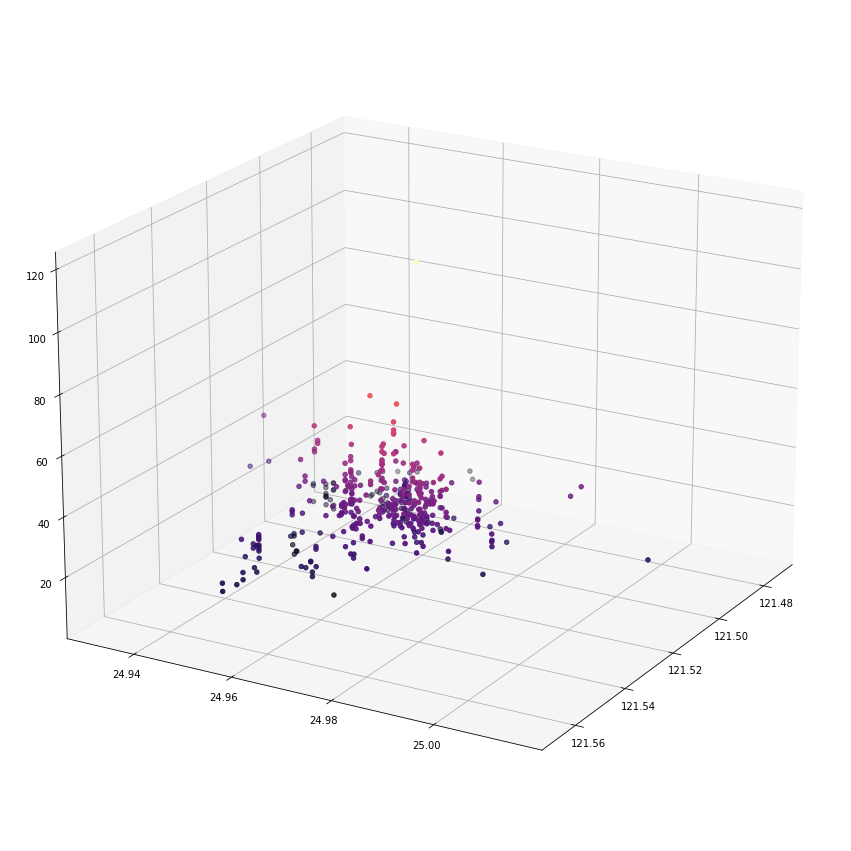

In [203]:
# Visualize a 3D plot of long/lat and housing price

fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(projection = '3d')
ax.scatter3D(data_df["X6 longitude"], data_df["X5 latitude"], data_df["Y house price of unit area"], c = data_df["Y house price of unit area"], cmap = 'magma')
ax.view_init(20, 30)


No single feature is strongly correlated with the observed outputs, however there are loose assosiciations that may allow us to find a linear association between the features and outputs. 

---

## Data Regularization
The next step in our project is to regularize the data. This reduces the spread of each features and reduces the range between features. I.e. if one feature is number of bedrooms (1-5), and another is total square footage (1000 - 5000), the difference in magnitude of each feature is enormous. By regularizing the data, we develop simlar scales between the data. 

In this step, we will also split the data into features and outputs and shuffle and divide the data into a training set and test set.

We will regularize the data using the equation:
$
\Large Z = \dfrac{\bar{X} - \mu}{\sigma}
$

In [204]:
# break down data for linear regression

# Regularization: z = (sample - mu)/sigma

# Convert dataframe to numpy array
data = data_df.to_numpy()

# toss the 'No' column, just lists the number of houses not a real datapoint
data = data[:,1:]

# Regularize features, not labels
x_data = data[:,:-1]

# find averages of each feature
mu = x_data.sum(axis=0)/data.shape[0]

# Calculate standard deviation of each feature
sigma = np.std(x_data, axis=0)

# regularize
r_data = (x_data-mu)/sigma

# Append column of 1s for bias
r_data = np.c_[np.ones(r_data.shape[0]), r_data]


---
## Splitting Data

Next, we must partition the data so we can train on a subset, then test and verify our model with a partition the model was not tuned on. This enhances our ability to know if our model has overfit the training data and understand the accuracy of future predictions. here, we will partition 2/3rds of the data to train on, and 1/3 of the data to test and verify on. 

In [205]:
# Split data into x = features and y = labels
y = data[:,-1]

X = r_data
#X = X[:,1:]
# Split into train, validate, test data. Shuffle data for better results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle=True, random_state=42)
X_train, X_Validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.33, shuffle = True, random_state=42)


---
## Create the model
In this project, we will implement the KNN regression algorithm from scikit-learn. [Scikit-learn](https://scikit-learn.org/stable/) is a machine learning library with a large variety of easy to implement machine learning tools and algorithms. Implementation is as easy as importing and calling the desired tool. Scikit-learn is a great resource for any machine learning project from data analysis to implementation, to performance and error analysis. 

In this model, we will import and configure [KNeighborsRegresssor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Once an instance is created, we pass the reference data using the "fit" function. We will then tune the number of nearest neighbors to find the number that produces the lowest number of errors. While it is not necessary, we will provide a visualization of the errors for each number of neighbors tested. 


Text(2, 89.78985401459857, 'Minimum MSE')

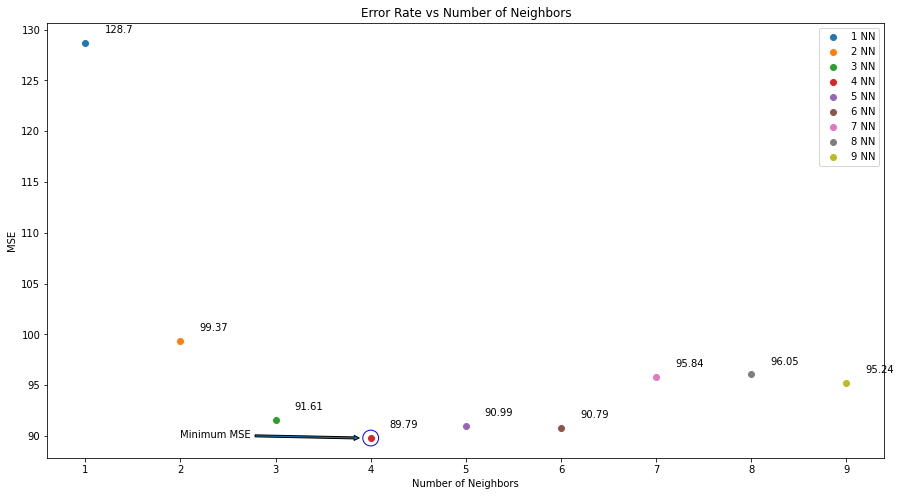

In [206]:
# Import the KNN regression module
from sklearn.neighbors import KNeighborsRegressor
i_all = []
neigh = []
error = []

# dummy value to keep indexes tidy
neigh.append(100)
error.append(100)
# For visualization
fig, ax = plt.subplots(1,1, figsize = (15,8))

for i in range(1, 10):
    # Create and fit a model for each neighbor
    neigh.append(KNeighborsRegressor(n_neighbors=i))
    neigh[i].fit(X_train, y_train)

    i_all.append(i)
    # Predict and plot errors
    y_hat = neigh[i].predict(X_Validate)
    # MSE
    error.append((1/X_test.shape[0])*sum((y_hat - y_validate)**2))
    ax.text(i+.2, error[i]+1, str(np.round(error[i],2)))
    # Plot
    ax.scatter(i, error[i], label = str(i) + " NN")

# Add labels and titles
ax.legend()
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("MSE")
ax.set_title("Error Rate vs Number of Neighbors")

# Circle minimum point
min_value = min(error)
idx = error.index(min_value)
ax.scatter(idx, min_value, s = 250, facecolors = 'none', edgecolors = 'b')

# Add an arrow
ax.annotate("Minimum MSE", xy=(idx-.1, min_value), xytext = (idx-2, min_value), arrowprops=dict(arrowstyle="simple"))

---
# Performance evaluation
Now that we have tuned the best number of neighbors, we can predict against the test set to determine how well our model performs. 

---
## Results Visualization

Now that our model has been trained, we van see how well our predictions align with the actual results of the test sets. We can deconstruct the feature vector and plot the input featurs vs the predictions and the actual results so see how well we perform. 

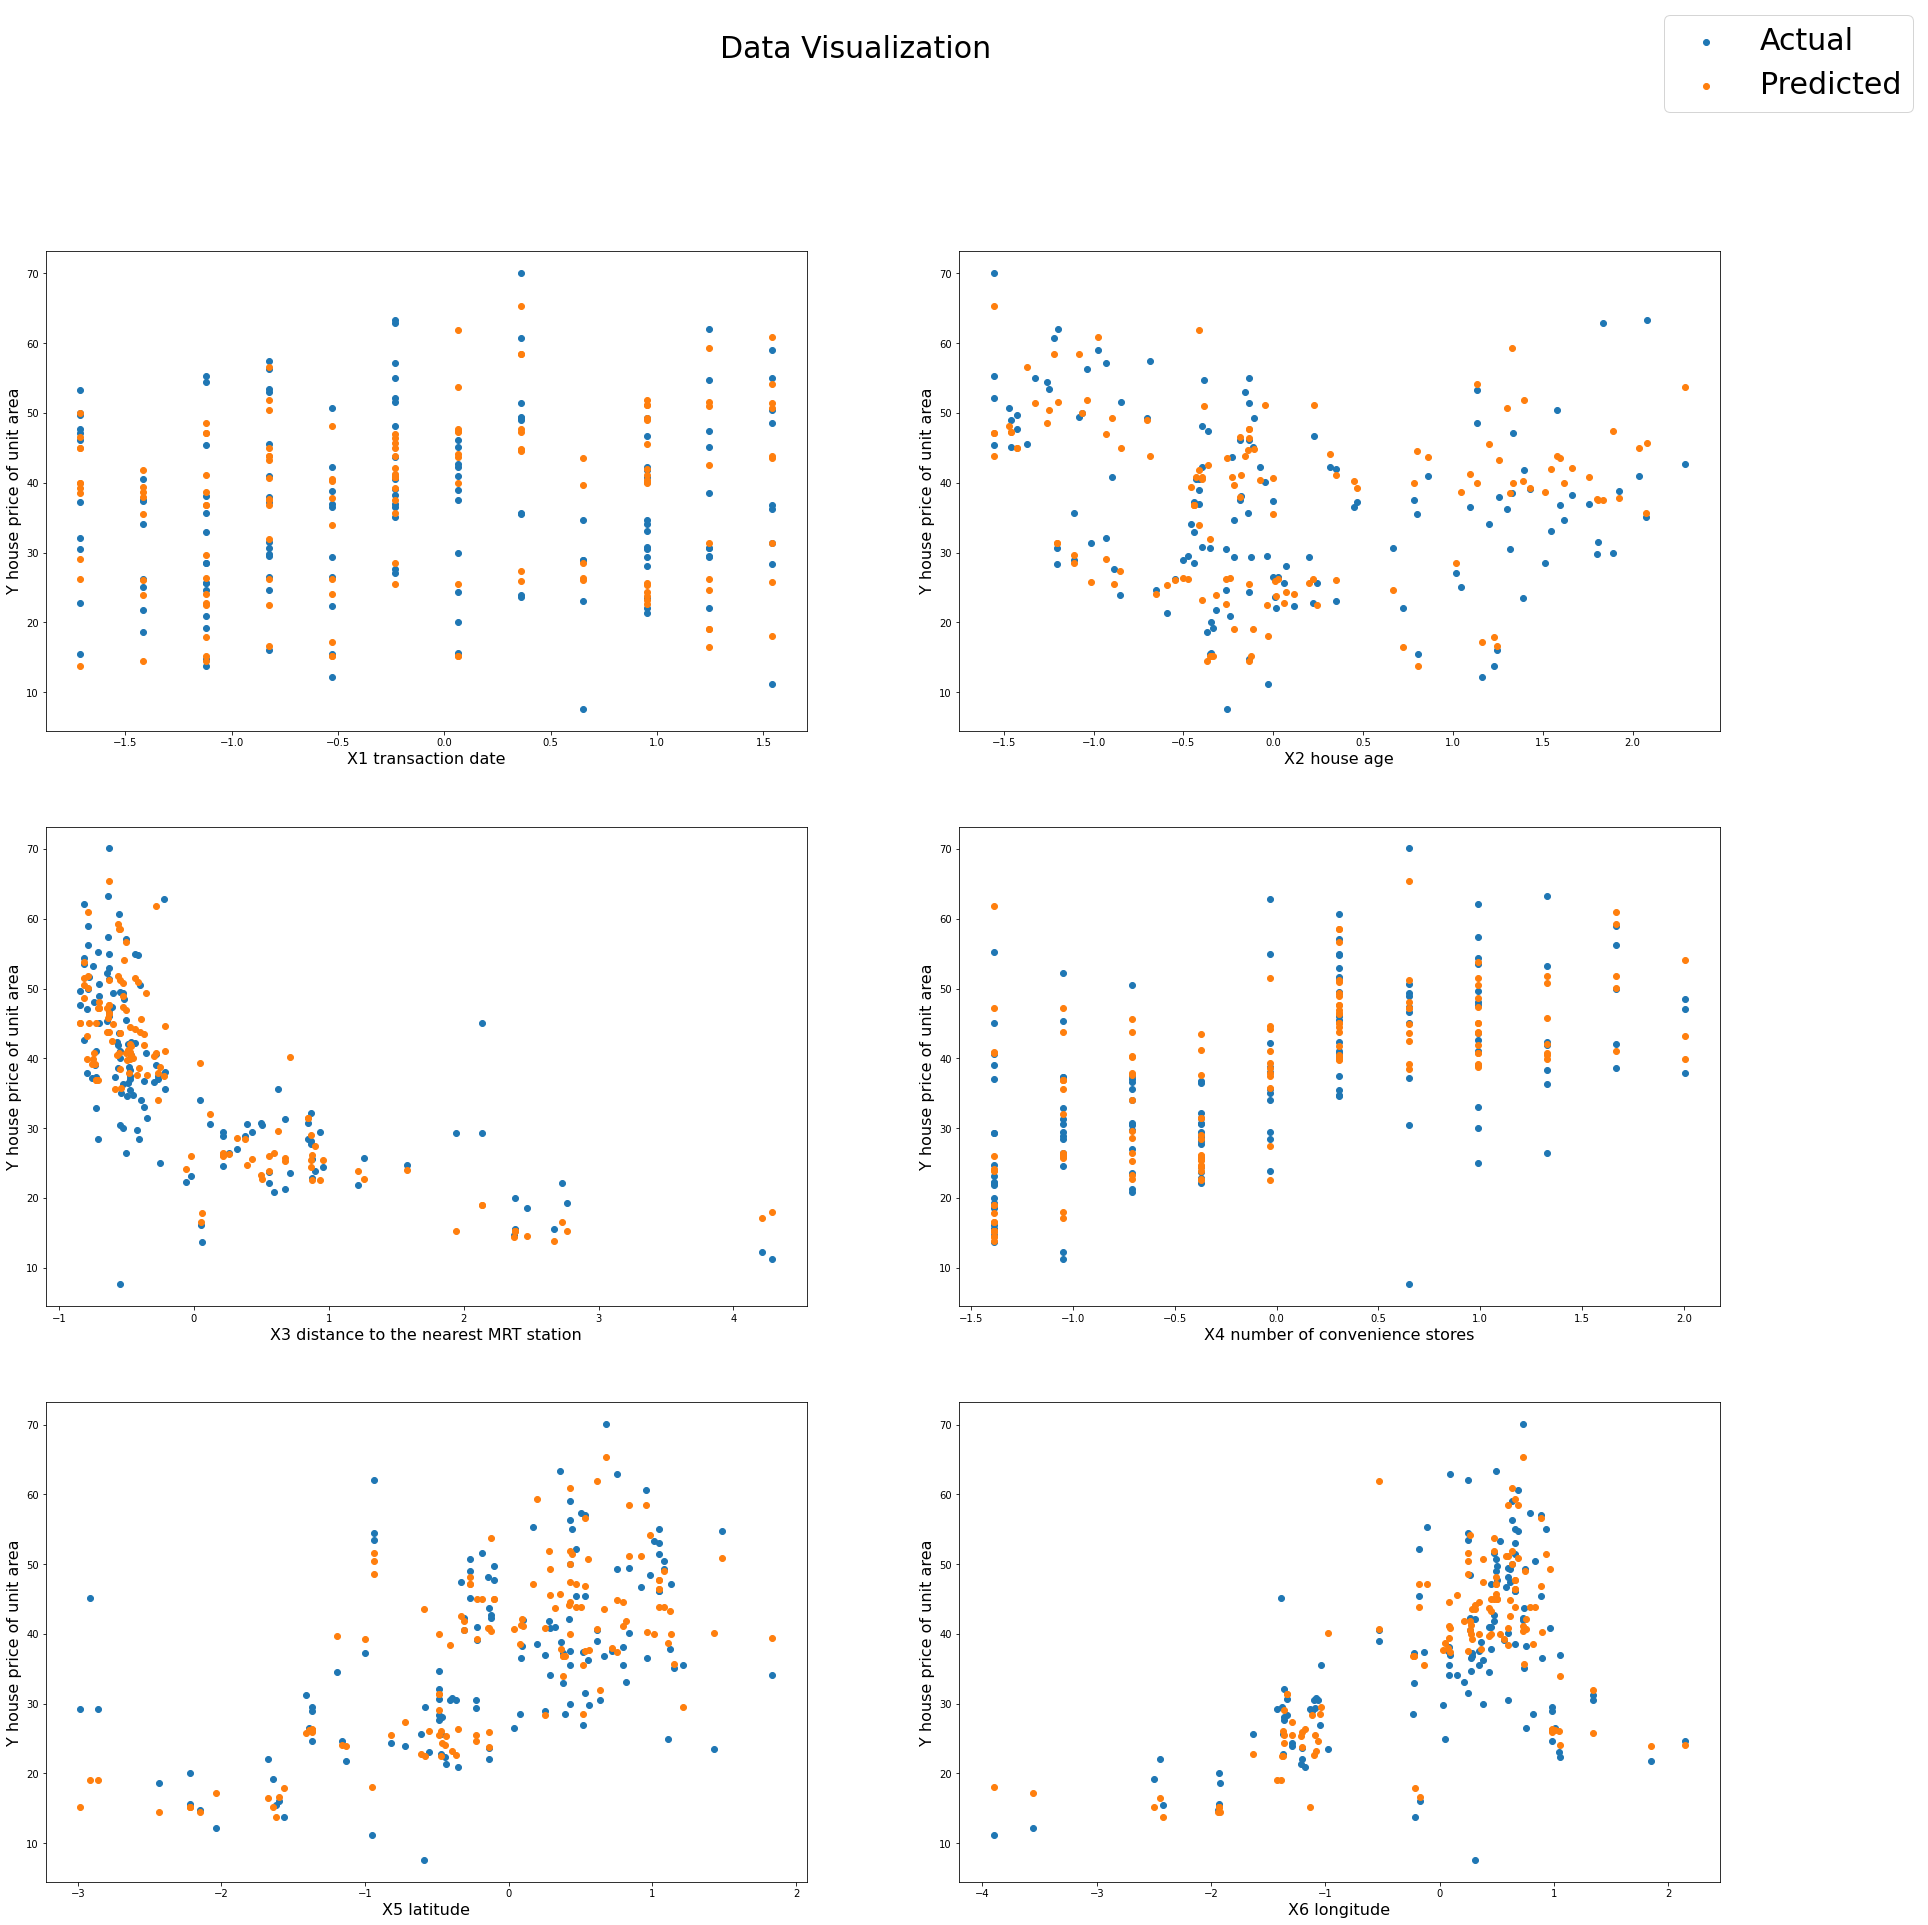

In [207]:
# Plot data to identify trends
fig, axs = plt.subplots(3,2)

# Need a big figure
fig.set_size_inches(30, 30)

# Label figure
fig.suptitle("Data Visualization", fontsize = 30)
label = y_test

# Add the validation set for better predictions
X_train = np.concatenate((X_train, X_Validate))
y_train = np.concatenate((y_train, y_validate))

neigh[idx].fit(X_train, y_train)

# Predict against the test set
y_hat = neigh[idx].predict(X_test)

u=0
v=0

# Plot each feature against the price/sqft
for i in range(1, X_test.shape[1]):
    axs[v,u].scatter(X_test[:,i], label)
    axs[v,u].scatter(X_test[:,i], y_hat)
    axs[v,u].set_xlabel(data_df.columns[i], fontsize = 16)
    axs[v,u].set_ylabel(data_df.columns[-1], fontsize = 16)

    # These are not the droids you're looking for
    u += 1
    if u > 1:
        u = 0
        v += 1
    if v > 2:
        v = 0

fig.legend(["Actual", "Predicted"], fontsize = 30)


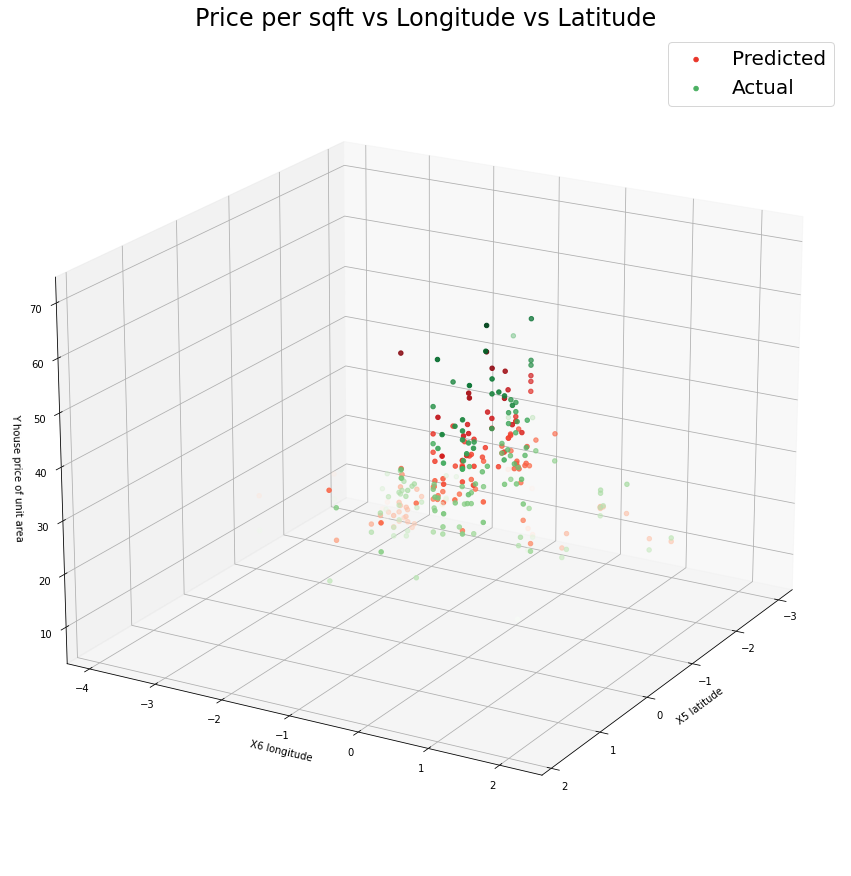

In [208]:
# Visualize a 3D plot of long/lat and housing price

fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(projection = '3d')

ax.scatter3D(X_test[:,5], X_test[:,6], y_hat, c = y_hat, cmap = 'Reds', label = "Predicted")
ax.scatter3D(X_test[:,5], X_test[:,6], y_test, c = y_test, cmap = 'Greens', label = "Actual")

ax.set_xlabel(data_df.columns[5])
ax.set_ylabel(data_df.columns[6])
ax.set_zlabel(data_df.columns[-1])

ax.set_title("Price per sqft vs Longitude vs Latitude", fontsize = 24)
ax.legend(fontsize = 20)
ax.view_init(20, 30)

Linear regression attempts to describe a linear relationship within the data. Variance and outliers greatly affect the ability of a linear regression algorithm's accuracy. Above, we can see the algorithm's predictions are concentrated on the bulk of the data and the errors increase the further it is from the highest concentration. 

---

# Error Analysis
There are several ways to judge the efficacy of reggression algorthims. Three of the most prominent are [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error), [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), and [$R^2$ Error](https://en.wikipedia.org/wiki/Coefficient_of_determination).

## Mean Squared Error
$
MSE = \frac{1}{n}\sum_{i=1}^{n}(\hat{y} - y)^2
$

Mean Squared Error assesses the quality of a predictor my measuring the average squared difference between the true and predicted values. The MSE incorporates both the variance and bias of the estimator. The best possible score is 0.

## Mean Absolute Error

$
MAE = \frac{1}{n}\sum_{i=1}^{n}|\hat{y} - y|
$

While MAE is closely related to MSE, it provides the average distance between the predicted cooridnate and true coordinate. The best possible score is 0.

In [209]:
# MSE
MSE = (1/X_test.shape[0])*sum((y_hat - y_test)**2)
print(f"Mean Squared Error: {np.round(MSE,2)}")

# MAE
MAE = (1/X_test.shape[0])*sum(np.abs((y_hat - y_test)))
print(f"Mean Absolute Error: {np.round(MAE,2)}")


Mean Squared Error: 65.66
Mean Absolute Error: 5.76


---
# Variations
The main variation of KNN regression is the weighted KNN. Weighted KNN applies a heavier weight to neighbors closest to the datapoint. The intuition behind this is the closest neighbors have a higher probability of predicting the correct labels. Below, we will compare the uniformly weighted, and distance weighted KNN. 

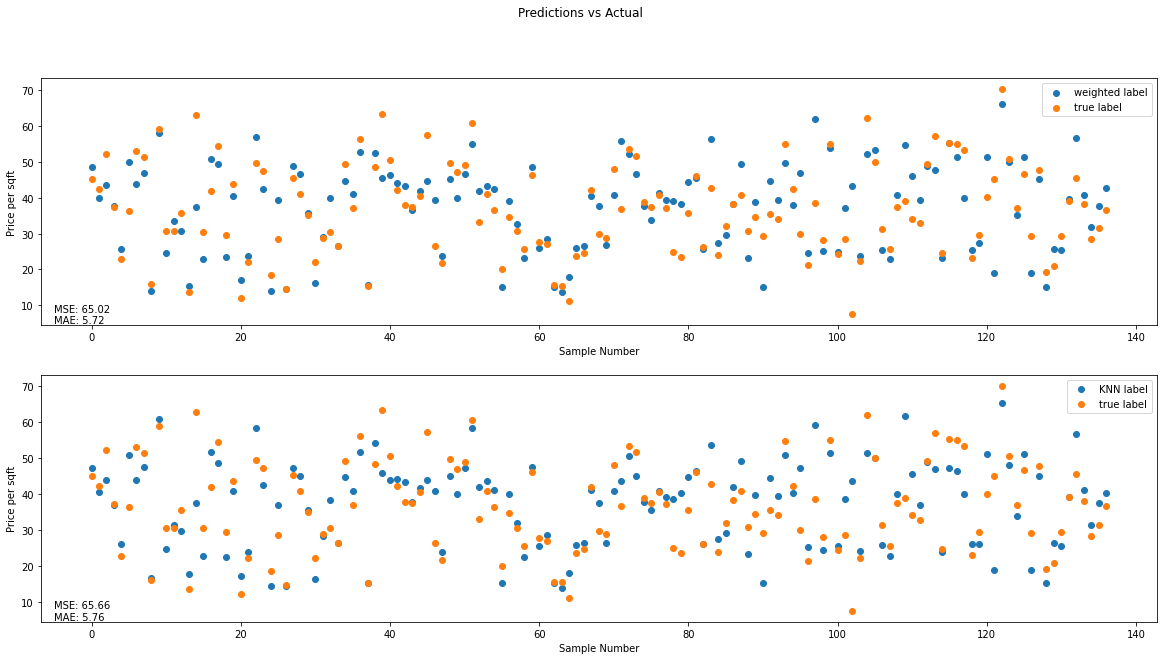

In [215]:
# Weighted 
w_neigh = KNeighborsRegressor(n_neighbors=idx, weights = 'distance')
w_neigh.fit(X_train, y_train)

w_y_hat = w_neigh.predict(X_test)

# MSE
w_MSE = (1/X_test.shape[0])*sum((w_y_hat - y_test)**2)
#print(f"Mean Squared Error: {np.round(MSE,2)}")

# MAE
w_MAE = (1/X_test.shape[0])*sum(np.abs((w_y_hat - y_test)))
#print(f"Mean Absolute Error: {np.round(MAE,2)}")

w_errors = "MSE: " + str(np.round(w_MSE,2)) + "\n" + "MAE: " + str(np.round(w_MAE,2))
errors = "MSE: " + str(np.round(MSE,2)) + "\n" + "MAE: " + str(np.round(MAE,2))

fig, ax = plt.subplots(2, 1, figsize = (20,10))
fig.suptitle("Predictions vs Actual")

ax[0].scatter(range(X_test.shape[0]), w_y_hat, label = "weighted label")
ax[0].scatter(range(X_test.shape[0]), y_test, label = "true label")
ax[0].text(-5,5, w_errors)
ax[0].set_xlabel("Sample Number")
ax[0].set_ylabel("Price per sqft")
ax[0].legend()

ax[1].scatter(range(X_test.shape[0]), y_hat, label = "KNN label")
ax[1].scatter(range(X_test.shape[0]), y_test, label = "true label")
ax[1].text(-5,5, errors)
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("Price per sqft")
ax[1].legend()


The distance weighted KNN peformed moderatly better than the uniformly weighted KNN. Both models, however, performed better than the Linear Regression model. 

With linear regression, we achieved the following:

Mean Squared Error: 71.49

Mean Absolute Error: 6.09

R-square: 0.55

The increase in accuracy is likely due to the non-linearity of our data and the assosiative nature of KNN. Our linear regression model attempted to decrease the amount of errors leading to a best-fit line through the highest concentration of the data whereas KNN makes a prediction based on previously seen values. 